## Pseudo-elastic Equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
%matplotlib inline

# Make background for figures white
plt.rcParams['figure.facecolor'] = 'white'

In [44]:
def plot_fn_snapshot(fn, fig=None, axs=None, **kwargs):
    if fig is None and axs is None:
        fig, axs = plt.subplots(1, 1)
        im = axs.imshow(fn, **kwargs)
        return fig, axs, im
    
    im = axs.imshow(fn, **kwargs)
    return fig, axs, im

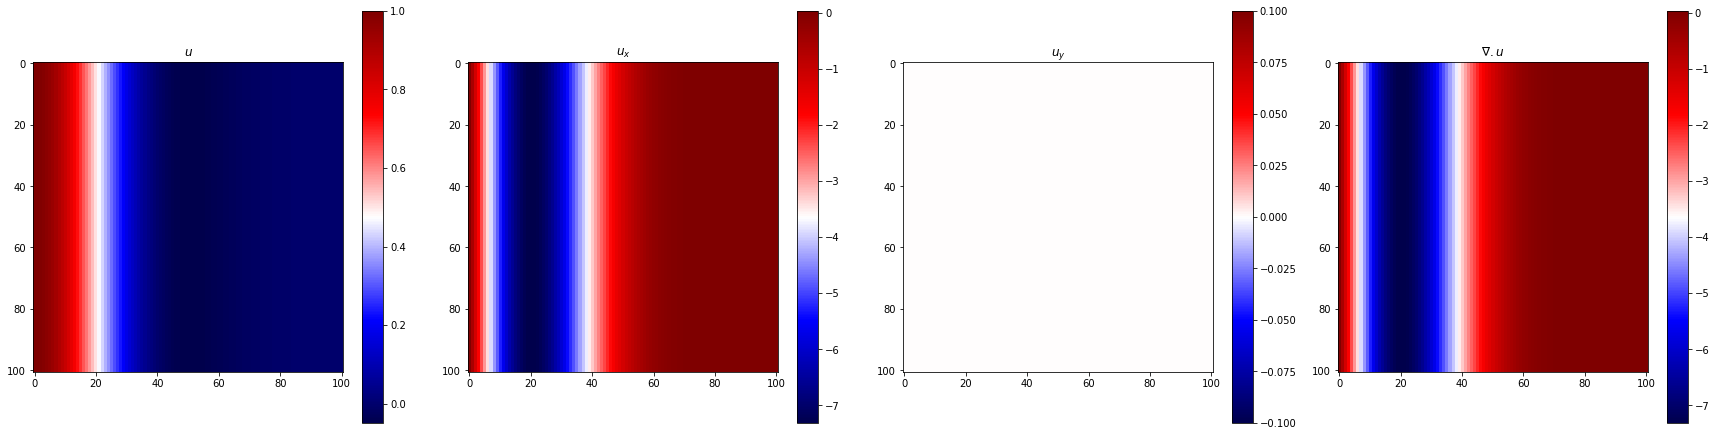

In [169]:
size = (101, 101)
u_initial = np.zeros(size)
u_dx = np.zeros(size)
u_dy = np.zeros(size)
# Set initial condition velocity
f = 1   # Wavelet frequency(Hz(?))
for i in range(size[0]):
    y = 1 - i / (size[0] - 1)
    for j in range(size[1]):
        x = j / (size[1] - 1)
#         Simple sine wave (x)
#         u_initial[i, j] = np.sin(2 * np.pi * x)
#         u_dx[i, j] = 2 * np.pi * np.cos(2 * np.pi * x)
#         u_dy[i, j] = 0

#         Ricker wavelet (x)
        u_initial[i, j] = (1 - 2*np.pi*f**2*x**2)*np.exp(-1 * np.pi**2 * f**2 * x**2)
#         u_dy[i, j] = 0
        u_dx[i, j] = ((np.exp(-1 * np.pi**2 * f**2 * x**2)*(-2*x*np.pi**2 * f**2)) * (1 - 2*np.pi*f**2*x**2) + 
                      (-2 * np.pi**2 * f**2 * 2 * x) * np.exp(-1 * np.pi**2 * f**2 * x**2)
                     )
#         Simple polynomial
#         u_initial[i, j] = 2 * (x-0.5)**2 - 9 * y
#         u_dx[i, j] = 4 * (x-0.5)
#         u_dy[i, j] = -9

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
_, _, im0 = plot_fn_snapshot(u_initial, axs=axs[0], cmap='seismic')
_, _, im1 = plot_fn_snapshot(u_dx, axs=axs[1], cmap='seismic')
_, _, im2 = plot_fn_snapshot(u_dy, axs=axs[2], cmap='seismic')
_, _, im3 = plot_fn_snapshot((u_dx + u_dy), axs=axs[3], cmap='seismic')
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.colorbar(im2, ax=axs[2])
fig.colorbar(im3, ax=axs[3])
axs[0].set_title(r"$u$")
axs[1].set_title(r"$u_x$")
axs[2].set_title(r"$u_y$")
axs[3].set_title(r"$\nabla . u$")
fig.tight_layout(pad=0.5)

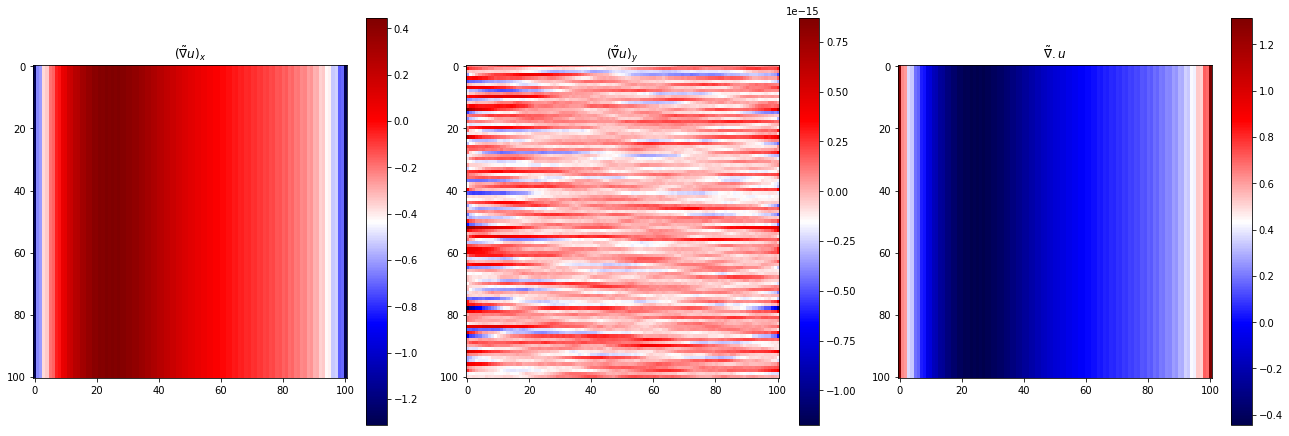

In [170]:
def normalized_gradient(f, dim=2, eps=1e-6):
    size = f.data.shape
    f_x, f_y = fft.fftfreq(size[1]), fft.fftfreq(size[0])
    f_fft = fft.fftn(f)
#     norm_grad = np.zeros((f.shape[0], f.shape[1], dim), dtype=complex)
    ddx = np.zeros(f.shape, dtype=complex)
    ddy = np.zeros(f.shape, dtype=complex)
    for i in range(f_fft.shape[0]):
        for j in range(f_fft.shape[1]):
            k_x, k_y = f_x[j], f_y[i]
            ddx[i, j] = -(1j * k_x) * f_fft[i, j]  / np.sqrt(k_x**2 + k_y**2 + eps)
            ddy[i, j] = -(1j * k_y) * f_fft[i, j]  / np.sqrt(k_x**2 + k_y**2 + eps)
    ddx = fft.ifftn(ddx)
    ddy = fft.ifftn(ddy)
    return ddx, ddy

def normalized_div(f, dim=2, eps=1e-6):
    ddx, ddy = normalized_gradient(f, dim=dim, eps=eps)
    return -(ddx + ddy)

# fig, axs = plt.subplots(1, 2)
ddx, ddy = normalized_gradient(u_initial)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

fig, axs[0], im0 = plot_fn_snapshot(np.real(ddx), fig=fig, axs=axs[0], cmap='seismic')
cbar0 = fig.colorbar(im0, ax=axs[0])
axs[0].set_title(r"$(\tilde{\nabla}u)_x$")

fig, axs[1], im1 = plot_fn_snapshot(np.real(ddy), fig=fig, axs=axs[1], cmap='seismic')
cbar1 = fig.colorbar(im1, ax=axs[1])
axs[1].set_title(r"$(\tilde{\nabla}u)_y$")
n_div = normalized_div(u_initial)
fig, axs[2], im2 = plot_fn_snapshot(np.real(n_div), fig=fig, axs=axs[2], cmap='seismic')
cbar2 = fig.colorbar(im2, ax=axs[2])
axs[2].set_title(r"$\tilde{\nabla} . u$")
fig.tight_layout(pad=0.5)

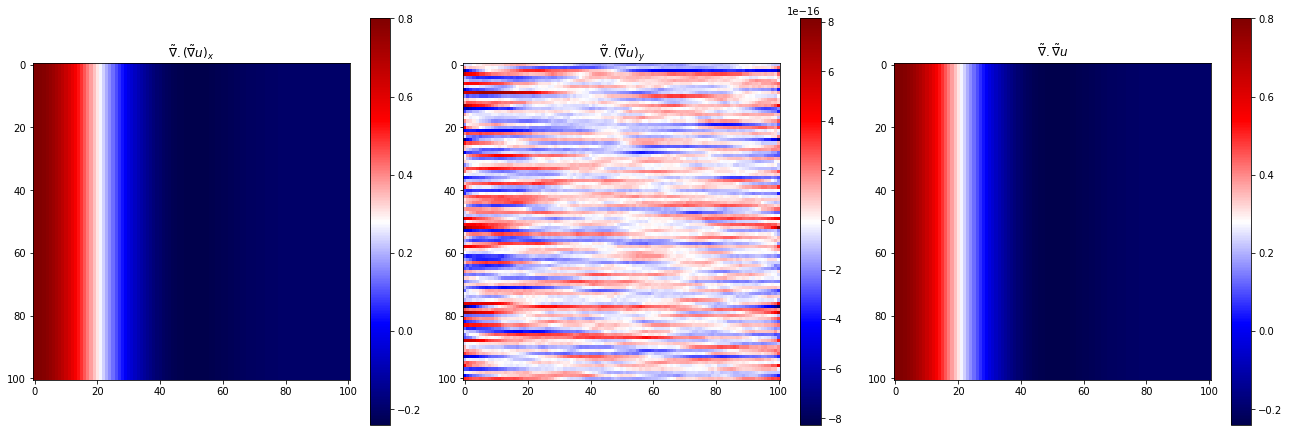

In [171]:
div_ddx = normalized_div(ddx)
div_ddy = normalized_div(ddy)
div_grad_u = div_ddx + div_ddy
# plt.imshow(np.real(div_grad_u), cmap='seismic')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
_, _, im0 = plot_fn_snapshot(np.real(div_ddx), fig=fig, axs=axs[0], cmap='seismic')
_, _, im1 = plot_fn_snapshot(np.real(div_ddy), fig=fig, axs=axs[1], cmap='seismic')
_, _, im2 = plot_fn_snapshot(np.real(div_grad_u), fig=fig, axs=axs[2], cmap='seismic')
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.colorbar(im2, ax=axs[2])
axs[0].set_title(r"$\tilde{\nabla} . (\tilde{\nabla} u)_x$")
axs[1].set_title(r"$\tilde{\nabla} . (\tilde{\nabla} u)_y$")
axs[2].set_title(r"$\tilde{\nabla} . \tilde{\nabla} u$")
fig.tight_layout(pad=0.5)

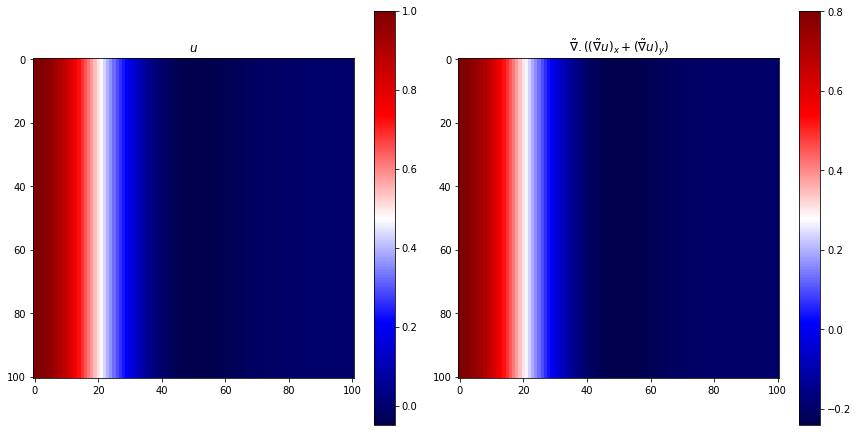

In [180]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
_, _, im0 = plot_fn_snapshot(np.real(u_initial), fig=fig, axs=axs[0], cmap='seismic')
_, _, im1 = plot_fn_snapshot(np.real(div_grad_u), fig=fig, axs=axs[1], cmap='seismic')
axs[0].set_title("$u$")
axs[1].set_title(r"$\tilde{\nabla} . ((\tilde{\nabla} u)_x + (\tilde{\nabla} u)_y)$")
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.tight_layout(pad=0.5)

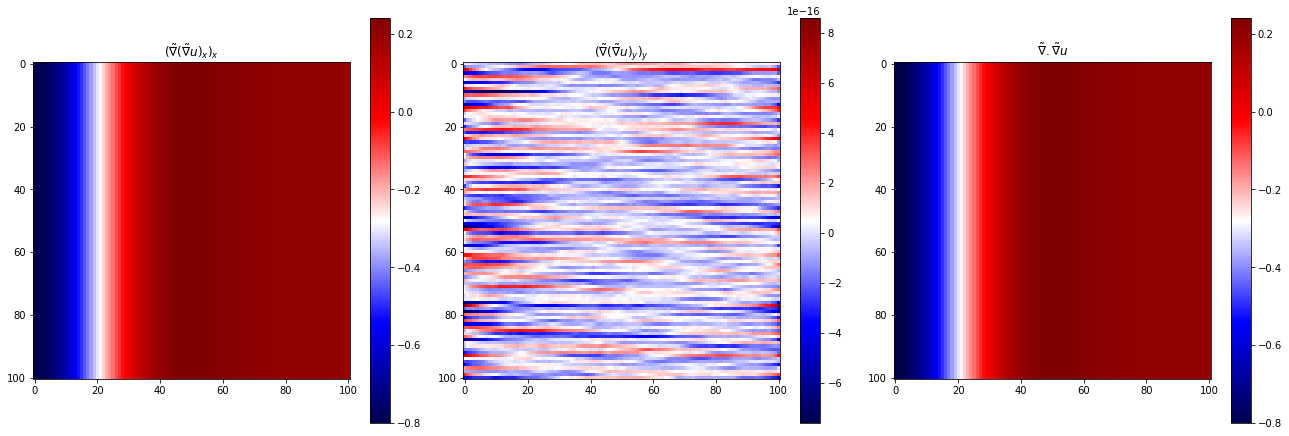

In [173]:
ddx_ddx, _ = normalized_gradient(ddx)
_, ddy_ddy = normalized_gradient(ddy)
laplace_u = ddx_ddx + ddy_ddy
# plt.imshow(np.real(div_grad_u), cmap='seismic')
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
_, _, im0 = plot_fn_snapshot(np.real(ddx_ddx), fig=fig, axs=axs[0], cmap='seismic')
_, _, im1 = plot_fn_snapshot(np.real(ddy_ddy), fig=fig, axs=axs[1], cmap='seismic')
_, _, im2 = plot_fn_snapshot(np.real(laplace_u), fig=fig, axs=axs[2], cmap='seismic')
fig.colorbar(im0, ax=axs[0])
fig.colorbar(im1, ax=axs[1])
fig.colorbar(im2, ax=axs[2])
axs[0].set_title(r"$(\tilde{\nabla} (\tilde{\nabla} u)_x)_x$")
axs[1].set_title(r"$(\tilde{\nabla} (\tilde{\nabla} u)_y)_y$")
axs[2].set_title(r"$\tilde{\nabla} . \tilde{\nabla} u$")
fig.tight_layout(pad=0.5)

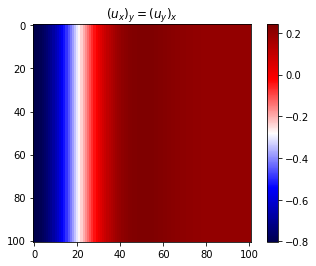

In [179]:
ddx_ddy = (laplace_u - div_grad_u) / 2
fig, axs, im = plot_fn_snapshot(np.real(ddx_ddy), cmap='seismic')
axs.set_title(r"$(u_x)_y = (u_y)_x$")
fig.colorbar(im)